# Deep Learning
### Week 7: Transformers

## Contents

[1. Introduction](#introduction)

[2. Motivation and problem setting](#motivation)

[3. Input and output embeddings](#embeddings)

[4. Multi-head attention](#multihead_attention)

[5. Positional encoding](#positional_encoding)

[6. Layer normalisation](#layernorm)

[7. Transformer architecture](#transformer)

[8. Attention layers (\*)](#attention_layers)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last weeks of the module we have studied two very important deep learning architectures: the convolutional neural network (CNN) and the recurrent neural network (RNN). We have seen how each of these models makes certain assumptions about the data that is reflected in the architecture design; CNNs make an equivariance assumption that makes them suitable for image data for example, whereas RNNs are often a good choice for sequential data.

In this week of the course, we will take a detailed look at the Transformer architecture. This is another type of network architecture that has become very popular. The Transformer is a very flexible architecture, which can be used for sequence modelling tasks just like RNNs. In fact this is the setting that the Transformer was originally developed for. However, it's since been extended and further developed to work for other types of data and problem tasks, including image classification, which is a setting that CNNs are well known for.

Popular implementations and applications of the Transformer include machine translation ([Vaswani et al 2017](#Vaswani17), [Liu & Chen 2021](#Liu21)), protein structure prediction ([Jumper et al 2021](#Jumper21)), the language models BERT ([Devlin et al 2018](#Devlin18)), GTP-3 ([Brown et al 2020](#Brown20)), LaMDA ([Thoppilan et al 2022](#Thoppilan22)) and PaLM ([Chowdhery et al 2022](#Chowdhery22)), image classification ([Dosovitskiy et al 2021](#Dosovitskiy21)) and audio modelling ([Borsos et al 2022](#Borsos22)).

As we'll see, the Transformer is quite a complicated architecture, consisting of many components. Throughout the course of this week, we will step through each of these components to gradually piece together the complete architecture.

The main feature that the Transformer makes use of is an attention mechanism, which is a kind of layer operation that we build into the Transformer model that allows the model to explicitly select certain features to focus on when making its predictions. This mechanism also gives us an extra degree of interpretability, in the sense that we can look inside the network to examine which parts of the input it's attending to.

We will also take a look at layer normalisation, which is an alternative normalisation to batch normalisation that is used in the Transformer. 

In order to make the exposition more focused and explicit, we will use the problem task of machine translation as a running example throughout the week.

<a class="anchor" id="motivation"></a>
## Motivation and problem setting

The following illustration, reproduced from the original Transformer paper ([Vaswani et al 2017](#Vaswani17)), shows the high-level schematic diagram of the Transformer model.

<img src="figures/full_architecture.png" alt="The Transformer architecture" style="width: 400px;"/>
<center>The Transformer architecture</center>

There are quite a few components that make up this complex model. Some components will be familiar, but some are new and will be introduced in this week.

#### Motivation

First however, we will provide some motivation for why the Transformer was developed, what problems it tries to address, and the properties that we'd like it to have. In the original paper, the Transformer was proposed as a model for machine translation, and also natural language parsing, although the authors did suggest that it could also be applicable for other tasks. And the Transformer has since been further extended from these original applications, to problems such as image classification, image captioning, and generative models of natural language and images, even conditioned on a caption input. 

The Transformer is now ubiquitous in deep learning, and it's a very versatile and powerful paradigm. But for the moment, let's consider the Transformer to be primarily a model for sequence data such as natural language. 

One of the main motivations for the development of the Transformer was something that we've encountered before in sequence modelling, which is the ability to model long-range dependencies in the data. We have already seen how this problem arises in the context of recurrent neural networks, and the LSTM architecture that was proposed to mitigate it. But even with the LSTM, there's a long signal path that information has to travel between two events that are many time steps apart. The signal has to travel through the hidden representation of the network, for every single time step, and so the path grows linearly in the number of time steps separating the two events. So even though the LSTM goes a long way to mitigate this problem with its internal memory cell, in practice it still struggles to successfully model very long range dependencies that you might find for example in a text document, where the meaning in one part of the document might depend on information that came several sentences or even paragraphs earlier.

Another related motivation (or benefit) of the Transformer is a practical one, and that is to be able to effectively scale or parallelise the training of the model across very long sequences. Throughout the course, we've seen how deep learning models are trained using minibatches of data. One of the nice things about computing gradients on a minibatch is that it's easily parallelisable. If we use minibatches of size 64 and we have 4 GPUs available to use, we can break the mini batch into 4 groups of 16, and have each GPU compute the gradient on 16 of the samples in the mini batch. After that's been done, the gradients can be gathered back together to do the parameter update. This type of parallelisation is very common in practice when training large models, and is often referred to as data parallelisation. But another type of parallelisation that's possible is model parallelisation, and this where parts of the model computation are sent out to different devices that are available. 

This is another way of speeding up or scaling the training, but its feasibility depends on the model architecture. With recurrent neural networks it's not possible to independently distribute the computation on different parts of the sequence to different devices, because of the inherently sequential nature of the model, and the fact that each hidden state depends on all the previous hidden states in the sequence. With convolutional neural networks, model parallelisation is more feasible. However, a drawback to using convolutional networks for sequence data comes from the first point of long-range dependencies: in a CNN, the signal path that connects information between two events that are many time steps apart, can be very long. So CNNs will also struggle to model long-range dependencies when applied to sequential data.

Another big point to stress about Transformers is an architectural design choice. For high-dimensional data inputs, at some point in the model architecture we would like to reduce the dimensionality. Convolutional neural networks do this through pooling operations. And with LSTMs, we hope that the cell state retains the relevant information for as long as it needs to, and discards whatever is irrelevant. Another motivation for the Transformer is that we want to give the network the ability to explicitly choose what information it keeps, and what it throws away. This is a key design feature of the Transformer called an attention mechanism.

The attention mechanism also makes the model more interpretable. It becomes easy to examine what parts of the data input the model is connecting together, and where it's looking in order to make it's predictions at each time step.

#### Problem setting

As mentioned already, the Transformer has now been developed for a wide range of problem tasks, but it's going to make it easier to understand what's going on if we fix a particular problem task to focus on.

So for this week, we will consider the problem of machine translation. In particular, say we want to train a Transformer to take in a sentence in one language (the source language), and then output the translation of that sentence in a target language.

<img src="figures/transformer_machine_translation.png" alt="The Transformer for machine translation" style="width: 800px;"/>
<center>Using a Transformer to translate from a source language (English) to a target language (German)</center>

We will use this application to focus on throughout the week, which will help to develop and think about all the different parts of the model architecture. By the end of the week it will become more clear how the Transformer can be adapted for other problem tasks. 

#### Encoder-decoder architecture

During the course of this week we will go through each of the components of the Transformer architecture. At a high level, the Transformer is an encoder-decoder architecture. 

<table>
  <tr>
      <td><center>Encoder</center></td>
      <td></td>
     <td><center>Decoder</center></td>
  </tr>
  <tr>
    <td><img src="figures/encoder_only_architecture_crop.png" width=180></td>
      <td></td>
    <td><img src="figures/decoder_only_architecture_crop.png" width=180></td>
  </tr>
 </table>

<center>The encoder and decoder stacks of the Transformer</center>

The block on the left hand side here is the encoder, whose job it is to take the source sentence and process it to produce a set of vector encodings that capture the meaning of the words within the source sentence, in such a way that will make it easier to translate. On the right hand side is the decoder part of the model, which receives the encodings from the encoder, which gives it the information it needs to produce the translation into the target language.

<a class="anchor" id="embeddings"></a>
## Input and output embeddings

The schematic diagram of the Transformer shows that it makes use of word token embeddings, which is something we have seen before with RNNs. This is a feature that is specific to the application of the Transformer to natural language.

In a machine translation model that's translating English into German, the input embedding part of the model will be taking an English sentence as input. We then apply a process of tokenisation, which means that this sentence is converted into a sequence of integer tokens.

A common way to do this tokenisation is to fix a maximum vocabulary size, and then take the most popular words seen in the corpus to populate the vocabulary. For each word in the vocabulary, we would then assign an integer index token. But this actually isn't how the Transformer does the tokenisation stage. Instead, it uses something called byte-pair encoding ([Sennrich et al 2015](#Sennrich15)). 

This course won't go into detail on byte-pair encoding, but just to give an overview: byte-pair encoding - or BPE - has been shown to be useful for NLP tasks. One of the nice features of this form of encoding is that it can efficiently handle cases where words are concatenated together, which often happens in natural language. BPE can handle this because it recognises and tokenises the subwords that it sees.

In the Transformer, the BPE is configured to the source and target language data combined. That means that the same tokenisation is applied to both languages. Or in other words, we use a shared vocabulary for both source and target languages. The encoding scheme will have a maximum vocabulary size that is a hyper parameter we need to set. 

In any case, the tokenisation stage has the effect of encoding our long sequences of text inputs into a compressed sequence of symbols. And it's these symbols that the Transformer actually uses to produce this sequence of integer tokens. Once we have this sequence of token indices, we can then use them in a lookup table of word embeddings. 

<img src="figures/input_embeddings.png" alt="The Transformer for machine translation" style="width: 700px;"/>
<center>Converting an input sentence to a sequence of integer tokens, and then embeddings</center>

Each of the word embeddings would be a vector, which we will assume is of size $d_{model}$. This is a fixed hidden vector size that is used throughout the Transformer.

This input embeddings component of the Transformer will output a variable-length sequence of embedding vectors in $\mathbb{R}^{d_{model}}$, which you can think of as a hidden representation. We will use the notation $\mathbf{h}_t$ for the hidden vector representation at time step $t$.

This hidden layer will then get sent on to the following layers in the encoder block of the Transformer.

The process is the same for the target or output sentences. Again, we use the same BPE scheme for tokenisation as we use for the input sentences, and also the same embedding lookup table to produce the sequence of embedding vectors. The target sentences could of course be a different length to the source sentences.

<img src="figures/output_embeddings.png" alt="The Transformer for machine translation" style="width: 700px;"/>
<center>Converting an output sentence to a sequence of integer tokens, and then embeddings</center>

These are the operations that are contained in the first embedding blocks you can see in the Transformer schematic diagram. There is an additional step before sending the embeddings into the encoder or the decoder, which is called a positional encoding. We will look at this later in the week.

<a class="anchor" id="multihead_attention"></a>
## Multi-head attention

The multi-head attention block is a key part of the Transformer model, and is what allows the Transformer to learn to focus on relevant parts of the input data in order to make its predictions. This mechanism also makes the model more interpretable, and allows us to analyse a trained Transformer model to see which parts of the data it is attending to at each stage of inference, and the concepts that it connects together. 

For the purpose of explaining the multi-head attention block, we will focus here just on the encoder stack.

<img src="figures/encoder_only_architecture_crop.png" alt="Encoder stack" style="width: 200px;"/>
<center>Encoder stack, including multi-head attention block in orange</center>

The attention block operates on vectors called queries, keys and values. The idea here is that each step in the sequence of hidden vectors emits a query vector. This query vector is then compared to the set of key vectors, to see which ones match well. Each key vector is paired with a value vector. For those key vectors that are a good match for the query, the corresponding value vectors get upweighted and sent on through the model for further processing.

These vectors come from the hidden layers of the model, in particular the hidden vectors $\mathbf{h}_t\in\mathbb{R}^{d_{model}}$ for each $t$. In the original implementation, $d_{model}=512$. We'll denote the key, value and query vectors with $k_t$, $v_t$ and $q_t$ respectively. The simplest case would be to just use the incoming hidden vector $\mathbf{h}_t$ for each of the key, value and query vectors, and use these values for the attention mechanism. The Transformer actually uses a further transformation to compute the query, key and value vectors, and in the general case, the query and key vectors will have size $d_k$ and the value vectors will have size $d_v$. For now, suppose that $q_t = k_t = v_t = \mathbf{h}_t$, and we will return to this point later.

In any case, at time step $t$, we have a query vector $q_t$. And what we do is to compare this query vector with all of the key vectors at every time step.

<img src="figures/query_key_vectors.png" alt="Query and key vectors" style="width: 800px;"/>
<center>Comparing the query vector $q_t$ with the key vectors from every time step</center>

We then compute a matching score between the query $q_t$ and each of these key vectors. There are choices of how to compute this matching (or similarity) score, but conventionally the Transformer computes this with a standard inner product between these pairs of vectors, to produce a similarity score $\overline{\alpha}_{t, i}$:

$$
\overline{\alpha}_{t, i} := \langle q_t, k_i \rangle,\qquad i, t = 1,\ldots, n, \tag{1}
$$

where $n$ is the length of the sequence. This will give us a similarity score at each time step for the query vector $q_t$, for $t=1,\ldots,n$. These scores could be any real value, and so the next step is to normalise this set of scores so they are all positive and sum to one. This is computed using the softmax function.

$$
\alpha_{t,i} := \frac{\exp({\overline{\alpha}_{t, i} / \sqrt{d_k}})}{\sum_{j=1}^n \exp({\overline{\alpha}_{t, j} / \sqrt{d_k}})} \tag{2}
$$

The normalised scores $\alpha_{t, i}$ are the weightings that we apply in the attention mechanism, that tell us where the Transformer should be looking in the sequence for relevant information. These weights are then used to compute a weighted combination of the value vectors at each time step:

$$
\mathbf{h}_t \leftarrow \sum_{j=1}^n \alpha_{t, j} v_j \tag{3}
$$

The attention mechanism will give us more of the value vectors that come from the parts of the sequence that are more relevFant for the time step we're currently computing.

This is then the output of the attention block for this time step $t$. This is the updated representation for this word token in the sequence, this is how the representation can take context of the word into account.

This attention computation is carried out for each of the time steps in the sequence. We can write the full collection of attention computations in the following compact form:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}}\right) V \tag{4}
$$

where the matrix $Q\in\mathbb{R}^{n\times d_k}$ is constructed by stacking the query vectors $q_t$ in the rows, for $t=1,\ldots,n$. Similarly, the rows of $K\in\mathbb{R}^{n\times d_k}$ contain the key vectors $k_t$ ($t=1,\ldots,n$) and $V\in\mathbb{R}^{n\times d_v}$ contain the value vectors $v_t$ ($t=1,\ldots,n$). 

Note that in the attention computation, the value vectors can in principle be a different size to the key and query vectors, but in practice we usually take them to be the same, so that $d_k = d_v$. 

NOTE THAT VALUES NEED NOT HAVE SAME SEQUENCE LENGTH n AS THE QUERIES. SINCE WE ONLY SUM OVER THEM, SO WHILE THEY MUST HAVE THE SAME DIMENSION dmodel, DONT NEED SAME LENGTH n. SAME LENGTH IS SELF ATTENTION, DIFFERENT LENGTH IS CROSS ATTENTION.

BUT IN THIS CASE OF CROSS-ATTENTION, THE MATRIX MULT IS NOT DEFINED, DO SUM INSTEAD.

In equation \eqref{attention_eqn}, the softmax is taken row-wise across its matrix argument.

The 'multi-head' part of this attention block comes from the observation that there could be multiple parts of the sequence that are relevant, that we'd like the model to be able to focus on. Instead of just a single attention block, the multi-head attention block uses several attention heads, so the model can focus its attention on multiple places at once. If we only use one attention head, then the model would learn to average over all the features that are relevant. But with multiple attention heads, it's able to focus with much better resolution in multiple areas. In the original paper, the authors used 8 attention heads in each multi-head attention block.

The multi-head attention block uses a collection of linear projection matrices to compute query, key and value vectors for each attention head:

$$
\text{head}_i = \text{Attention}\left( QW_i^Q, KW_i^K, VW_i^V \right),
$$

where $W_i^Q, W_i^K\in\mathbb{R}^{d_{model}\times d_k}$ and $W_i^V\in\mathbb{R}^{d_{model}\times d_v}$, and $i=1,\ldots,n_h$ where $n_h$ is the number of attention heads. Each of these linear projection matrices $W^Q_i$, $W^K_i$, and $W^V_i$ are learned during training. Here, should have $Q \in \mathbb{R}^{n \times d_{model} }$ so that the matrix multiplication is well defined, the same for the other two too, since they comes directly from h which has this dimension too.

In the original implementation, $d_v = d_k = 64 = d_{model} / n_h$, with the number of attention heads $n_h=8$.

As before, the matrix $Q\in\mathbb{R}^{n\times d_k}$ is constructed by stacking the query vectors $q_t$ in the rows, for $t=1,\ldots,n$ and similarly for $K\in\mathbb{R}^{n\times d_k}$ and $V\in\mathbb{R}^{n\times d_v}$. $QW_i^Q$, $KW_i^K$ and $VW_i^V$ are the matrices used in the attention computation for head $i$, and each head will output $n$ vectors of size $d_v$. 

The final stage is then to take the outputs from each attention head, and concatenate them:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,\ldots,\text{head}_{n_h})W^O, \tag{5}
$$

The concatenation of the output of each attention head produces a matrix of size $n\times n_hd_v$, which is equal to $n\times d_{model}$ with the choice $d_v = d_{model} / n_h$.

We then take one more linear projection $W_O\in\mathbb{R}^{n_hd_v\times d_{model}}$ to project back to the model dimensionality $d_{model}$. If we take the dimensions as in the original paper, then this is a square matrix, but in general it need not be.

That is the full set of computations used by the multi-head attention block of the transformer. To summarise, the main points are that the attention mechanism gives the model a way of updating each word representation in the sequence so that it can take the context of the full sentence input into account. We use multiple attention heads inside this block so that the model can focus its attention on different parts of the sequence at once.

#### Softmax scaling

Finally, there is one detail that is worth further explanation. In \eqref{normalised_similarity} there is an extra scaling in the softmax, where we are dividing all the $\overline{\alpha}_{t,i}$ values by $\sqrt{d_k}$. Recall that $d_k$ is the size of the query and key vectors.

The reason we do this is to normalise the inputs into the softmax so that the gradient information can flow through it more easily. This is related to a general property of the softmax. 

The issue is that the softmax can become saturated and the gradient vanishes, similar to what happens in the tails of the sigmoid activation function (note that in order to train our Transformer model we will need to take derivatives of this expression with respect to $\overline{\alpha}_{t,i}$).

Suppose instead that we had defined the normalising softmax function as follows:

$$
\alpha_{t,i} := \frac{\exp({\overline{\alpha}_{t, i}})}{\sum_{j=1}^n \exp({\overline{\alpha}_{t, j}})}\tag{6}
$$

The problem is that the query and key vectors can potentially be quite long vectors if the size $d_k$ is large. This means that the input logits to the softmax can vary wildly. Recall that $\overline{\alpha}_{t,i} = \langle q_t, k_i\rangle$, and $q_t, k_i \in\mathbb{R}^{d_k}$. 

If we assume that each entry of the vectors $q_t$ and $k_i$ had variance one:

$$
\text{Var}\left( [q_t]_j \right) = \text{Var}\left( [k_i]_j \right) = 1,
$$

and further we assume these entries have zero mean and are independent, then we have

$$
\text{Var}\left( \overline{\alpha}_{t, i}\right) = d_k.
$$

Then the scale of the logits $\overline{\alpha}_{t, i}$ could be very large if $d_k$ is large, and this would be a problem for the softmax \eqref{not_normalised_similarity}. In this scenario, the softmax saturates and the largest of the logits $\overline{\alpha}_{t, i}$ dominates, and all the other outputs of the softmax shrink to zero. This is a problem for the gradient flow, as the gradient will also converge to zero. 

Instead, by scaling the $\overline{\alpha}_{t, i}$ values by $1 / \sqrt{d_k}$, we obtain

$$
\text{Var}\left( \overline{\alpha}_{t, i}  / \sqrt{d_k} \right) = 1,
$$

which results in a non-saturated softmax that the gradient can more easily flow through.

<a class="anchor" id="positional_encoding"></a>
## Positional encoding

The lower part of the schematic diagram of the Transformer shows the positional encoding stage being applied to both the input embeddings and the output embeddings.

<img src="figures/positional_encoding_schematic.png" alt="Positional encoding schematic" style="width: 400px;"/>
<center>Positional encoding applied to both input and output embeddings</center>

These are extra encoding vectors that are added to the input embeddings and output embeddings before they are processed by the encoder or decoder stacks respectively.

Recall that the input (and output) embeddings block takes a sequence of words and tokenizes them into integer tokens. Each integer token will then correspond to its own embedding vector, so the embedding block outputs a sequence of embedding vectors each of size $d_{model}$. We can think of this as being a matrix of size $n\times d_{model}$, where $n$ is the number of tokens in the input sequence.

Before this matrix of embedding vectors is sent into the encoder (or decoder) block, we add some extra information with the positional encoding stage. This stage is necessary due to the way the computations are carried out in the multi-head attention block. Recall the equations for the multi-head attention:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V, \tag{7}
$$
$$
\text{head}_i = \text{Attention}\left( QW_i^Q, KW_i^K, VW_i^V \right), \tag{8}
$$
$$
\text{MultiHead}(Q, K, V) = \text{Concat} (\text{head}_1,\ldots,\text{head}_{n_h})W^O. \tag{9}
$$

The core attention equation is \eqref{attention_eqn_recap}, where a stack of query, key and value vectors are combined such that the inner product of query and key vectors gives us an unnormalised matching score between each position in the sequence, which is then normalised by the softmax function, and then used to weight the corresponding value vectors.

The multi-head attention block consists of a number of attention heads, and each head produces the queries, keys and values to use in the attention equation using learned projection matrices as in \eqref{attention_head_i_eqn_recap}.

The output of the attention heads are then concatenated at every step in the sequence, and finally passed through one more projection matrix $W^O$ to output $n$ vectors of dimension $d_{model}$ in \eqref{multihead_eqn_recap}.

The point to emphasise here is that the order of the input vector sequence is irrelevant within this multi-head attention block. Or in other words, for a set of query, key and value vectors, if we permute the order of the vectors, then the output of the multi-head attention block would be unchanged. That is, the multi-head attention block is _permutation invariant_.

This is a problem, since the order of the words in the input sequence is important. We should not expect that if we randomly jumble up the words in a natural language sentence that we could still identify the correct meaning and translation.

This is the reason that we have to include some information about the order of the words within the sequence of vectors that are being sent in to the multi-head attention block, so that the learned projections in the attention computation can take the order of the words into account. This information is provided by the additional positional encodings.

The Transformer implements this by computing a sequence of $n$ positional encoding vectors each of size $d_{model}$ (so that we can again combine them into a matrix of size $n\times d_{model}$ and directly adding them to the sequence of embedding vectors. It does this for the embedding vectors coming from both the input embedding and output embedding blocks.

There are various ways that positional information like this could be provided, but in a standard Transformer implementation, these positional encoding vectors are fixed and deterministic.

The main properties that we need from a positional encoding is that we should have a unique encoding vector for every position in the sequence, and ideally that the model should be able to generalise to sequence lengths that are rare or aren't present in the data.

The positional encoding scheme $\mathbf{P} \in\mathbb{R}^{n\times d_{model}}$ used in the original paper is as follows:

$$
\begin{align}
P_{ti} &= \left\{
\begin{array}{c}
\sin(\omega_k t)\quad\text{for }i=2k+1,\quad(\text{for some }k\in\mathbb{N}_0)\\
\cos(\omega_k t)\quad\text{for }i=2k+2\quad(\text{for some }k\in\mathbb{N}_0)
\end{array}
\right. \tag{10}\\
\omega_k &= \frac{1}{10000^{2k/d_{model}}},
\end{align}
$$

where $t=1,\ldots,n$ and $i=1,\ldots,d_{model}$. Again, we can think of the positional encodings as a stack of vectors of size $d_{model}$, one for each position in the sequence. For a given position in the sequence $t$, the entry of the matrix is either a sine or a cosine, depending on whether the dimension index $i$ is odd or even. So for each dimension index $i$, we have a sinusoidal sequence through the positions $t$, where the frequency decreases as the index $i$ increases. 

These positional encodings can be visualised as follows.

<img src="figures/positional_encodings.png" alt="Positional encodings" style="width: 600px;"/>
<center>Positional encodings for a sequence of length $n=400$, where $d_{model} = 512$</center>

At a fixed position $t$, the $d_{model}$-dimensional vector is as follows:

$$
\mathbf{P}[t,:] = \left[ \sin(\omega_0 t), \cos(\omega_0 t), 
\sin(\omega_1 t), \cos(\omega_1 t),
\ldots,
\sin(\omega_{d_{model} /2 -1} t), \cos(\omega_{d_{model} / 2 - 1} t)
\right],\tag{11}
$$

where we are assuming that $d_{model}$ is even.

In any case, these positional encoding vectors satisfy our requirements for being deterministic, and uniquely defining a position in the sequence. 

They also have the nice property that captures the relative position between two points in the sequence: for any fixed distance $m$ between two points in the sequence, we can relate the positional encoding vectors at these points with a linear transformation as follows: 

$$
\mathbf{A}(m)\mathbf{P}[t, :] = \mathbf{P}[t + m, :] \tag{12}
$$

Here $\mathbf{A}:\mathbb{N}_0 \mapsto \mathbb{R}^{d_{model}\times d_{model}}$ is a matrix-valued function of the distance $m \in\mathbb{N}_0$, where $m<n$ and $t\le n-m$. The important point to note here is that the matrix-valued function $\mathbf{A}$ here does not depend on the absolute time position $t$.

The reason why this is useful is that it makes it easier for the model to learn to focus on different parts of the sequence by relative position. For example, it should be easier to learn whether one word embedding vector comes before or after another word embedding.

The property \eqref{relative_position} holds with the matrix $\mathbf{A}(m)$ defined as

$$
\mathbf{A}(m) = \left[
\begin{array}{cccc}
R(\omega_0 m) & \mathbf{0} & \cdots & \mathbf{0} \\
\mathbf{0} & R(\omega_1 m) & \cdots & \mathbf{0} \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{0} & \mathbf{0} & \cdots & R(\omega_{d_{model} / 2 -1} m)
\end{array}
\right],
$$

where 

$$
R(\omega_k m) = \left[
\begin{array}{cc}
\cos(\omega_k m) & \sin(\omega_k m) \\
-\sin (\omega_k m) & \cos(\omega_k m)
\end{array}
\right] .
$$

Since $ \left[
\begin{array}{cc}
\cos(\omega_k m) & \sin(\omega_k m) \\
-\sin (\omega_k m) & \cos(\omega_k m)
\end{array}
\right] \left[
\begin{array}{c}
\sin(\omega_k m) \\
 \cos(\omega_k m)
\end{array}
\right] = \left[
\begin{array}{c}
\sin(\omega_k(t+m)) \\
 \cos(\omega_k(t+m))
\end{array}
\right] $, and there are pairs of sines and cosines for each frequency in the vector.

<a class="anchor" id="layernorm"></a>
## Layer normalisation


INDEPENDENT OF MINIBATCH SIZE 

Same computation is done at training and test tiume unlike batch norm where running average is used at test time.

Earlier in the course, we have seen how batch normalisation can be used as a way of normalising activation statistics in a neural network in order to facilitate training. In typical implementations, the Transformer model doesn't use batch normalisation, but instead uses another normalisation technique called layer normalisation ([Ba et al 2016](#Ba16)).

In the schematic diagram of the Transformer, you can see several places where layer normalisation is used in each of the yellow 'Add & Norm' blocks:

<img src="figures/encoder-decoder_cropped.png" alt="Encoder and decoder blocks" style="width: 300px;"/>
<center>Encoder and decoder blocks, including the blocks with layer normalisation</center>

The core motivation for layer normalisation is the same as for batch normalisation. We would like to normalise the activations in our network to facilitate training. This is particularly important very deep networks in practice. Normalising the activations increases the stability of the training process as well as the speed. In addition, layer normalisation has another couple of features that are quite attractive, in comparison to batch normalisation.

The first key property of layer normalisation is that it does not depend on the batch size during training. This is an important point in cases where we need to use small batch sizes for practical, computational reasons. For example, if we are training large models, then we  won't be able to fit the model processing a large mini batch of data on the GPU. Instead, we'd have to reduce the mini batch size to avoid memory problems. Applying deep learning to NLP problems in particular is often computationally expensive. In practice, training Transformer networks often requires us to use small batch sizes, and so layer normalisation comes in very useful.

The second key property of layer normalisation is that it uses the same computation at both training and test time. This is in contrast to batch normalisation, which keeps a running average of the mini batch statistics, and it's this running average that is used at test time.

First recap the computation carried out by batch normalisation:

$$
\begin{align}
\text{Compute activation statistics:}\quad &
\left\{
\begin{array}{c}
\mu^{(k)}_{jm} = \frac{1}{M} \sum_{i=1}^M h_{ij}^{(k)} \\
\left( \sigma_{jm}^{(k)}\right)^2 = \frac{1}{M} \sum_{i=1}^M (h_{ij}^{(k)} - \mu_{jm}^{(k)})^2
\end{array}
\right. \\
\text{Normalise and apply learned parameters:}\quad &
\left\{
\begin{array}{c}
\hat{h}_j^{(k)} = \frac{\large h_j^{(k)} - \mu_{jm}^{(k)}}{\sqrt{\left( \sigma_{jm}^{(k)} \right)^2 + \epsilon}} \\
z_j^{(k)} = \gamma_j^{(k)}\hat{h}_j^{(k)} + \beta_j^{(k)} 
\end{array}
\right.
\end{align}
$$

In the above equations, $h^{(k)}_{ij}$ is the post-activation for the $j$-th neuron in the $k$-th layer of the network, in the $i$-th example in the mini batch. epsilon is for stability. gamma and beta are learned and chosen to optimize the mean and variance per post activation value. WE GET THESE PER ACTIVATION. THEN STANDARDISE EACH ACTIVATION WRT ITS MEAN AND VAR JUST CALCULATED.

In contrast, the following equations show the computation carried out by layer normalisation:

$$
\begin{align}
\text{Compute activation statistics:}\quad &
\left\{
\begin{array}{c}
\mu^{(k)}_{i} = \frac{1}{n_k} \sum_{j=1}^{n_k} h_{ij}^{(k)} \\
\left( \sigma_{i}^{(k)}\right)^2 = \frac{1}{n_k} \sum_{j=1}^{n_k} (h_{ij}^{(k)} - \mu_{i}^{(k)})^2
\end{array}
\right. \\
\text{Normalise and apply learned parameters:}\quad &
\left\{
\begin{array}{c}
\hat{h}_j^{(k)} = \frac{\large h_j^{(k)} - \mu_{i}^{(k)}}{\sqrt{\left( \sigma_{i}^{(k)} \right)^2 + \epsilon}} \\
z_j^{(k)} = \gamma_j^{(k)}\hat{h}_j^{(k)} + \beta_j^{(k)} 
\end{array}
\right.
\end{align}
$$

In the above, $n_k$ is the number of neurons in the $k$-th hidden layer of the network. Layer normalisation also computes post activation statistics, but now we compute the mean and variance of the post activations across all of the neurons within a given layer. 

IN CONTRAST TO BATCHNORM, THIS IS DONE OVER THE NEURONS IN A LAYER, AND IS CALCULATED FOR EACH EXAMPLE IN THE MINIBATCH. HENCE CAN BE DONE INDEPENDENT OF BATCH SIZE, COULD HAVE MINIBATCH SIZE OF 1. THEN PROCEED AS IN BATCHNORM, BUT WE USE SAME MU AND SIGMA FOR EACH NEURON IN LAYER K WHEN NORMALISING. JUST DIFFERENT FOR EACH DATA POINT.

Note that these mean and variance statistics are computed individually for each example in the mini batch, so that we have a $\mu^{(k)}_i$ and a $\sigma^{(k)}_i$ for each $i$ from 1 to $M$, if $M$ is the size of the mini batch. Or in other words, the size of the mini batch or the selection of other examples within the mini batch is irrelevant. We could in the extreme case train with a mini batch size of one, and that's not a problem for layer normalisation.

Once we have these layer statistics, we then normalise the post activation values in layer k in a very similar way to before. This time however, notice that we're using the same $\mu^{(k)}_i$ and $\sigma^{(k)}_i$ values for each neuron in layer $k$.

The resulting normalisation results in the post activations of neurons within a layer having mean of zero and standard deviation of one, instead of having a mean of zero and standard deviation of one across the mini batch. The effect of the process is similar: we end up with a more controlled spread of activation values which makes the training easier.

And just as with batch normalisation, we use learnable parameters $\gamma_j^{(k)}$ and $\beta_j^{(k)} $ to shift and scale the post activation values. 

In the Transformer, layer normalisation is used in conjunction with the multi-head attention block. Recall that the input to the multi-head attention is a sequence of $n$ hidden vectors, each of size $d_{model}$. And the multi-head attention block will also output a sequence of hidden vectors of the same size.

<img src="figures/addnorm_multiheadattention.png" alt="Layer norm and multi-head attention" style="width: 600px;"/>
<center>Layer normalisation and multi-head attention in the Transformer</center>

The layer normalisation operates on the output of the multi-head attention block, but also includes a residual connection as you see in the diagram above. This means that the sequence of input hidden vectors are added to the sequence of output vectors we have coming out of the multi-head attention block. Both sequences have the same length and the vectors are the same size, and both can be thought of as a matrix of size $n\times d_{model}$, so it's not a problem to add them like this. 

This addition is the residual (or skip) connection. We then layer normalise each hidden vector in the sequence. This can be thought of as applying layer normalisation separately for each time step. The learned parameters of layer normalisation are shared across the time steps. This then gives us a final sequence of hidden vectors, again the same sequence length $n$ and the same vector size $d_{model}$.

#### Layer normalisation in RNNs

One of the original motivations for the development of layer normalisation given in the original paper ([Ba et al 2016](#Ba16)) was to do with recurrent neural networks. This section covers this original motivation, but it is not essential for the understanding of the Transformer, so is optional.

If we consider a regular recurrent neural network, and suppose that we would like to include batch normalisation in this model. A first approach might be include batch normalisation in the recurrent layer as follows:

<img src="figures/rnn_batchnorm_naive.png" alt="Batchnorm in RNNs" style="width: 600px;"/>
<center>Including batch normalisation in a recurrent layer</center>

However, it is not clear how this should work. How should we compute the mini batch statistics in these batch normalisation layers? In principle, we'd expect the distribution of activations could change significantly across the time steps. So it makes sense to collect the activation statistics independently for each time step. 

In this case, we'd end up with separate mean and standard deviation parameters at each time step. But this creates some problems. Recall one of the main benefits of RNNs is that they can be applied to variable length sequences. So it's quite possible that different data examples within a mini batch can have different sequence lengths.

So each of these mean and standard deviations could potentially be averaged over a different number of examples in the mini batch. The statistics that are calculated at later time steps are likely to have fewer and fewer examples in the mini batch to average over, and so will become more and more noisy. 

Furthermore, if we were to have an example at test time that's longer than any examples we've seen during training, we wouldn't be able to get predictions on the later time steps because we won't have been able to train the corresponding batch normalisation layer.

All in all, batch normalisation with RNNs is quite problematic.

<img src="figures/rnn_layernorm.png" alt="Layernorm in RNNs" style="width: 600px;"/>
<center>Including layer normalisation in a recurrent layer</center>

With layer normalisation, we don't have the same problems, because we're not averaging over the mini batch, so having different sequence lengths for different examples doesn't make any difference. We still compute mean and variance statistics separately for each time step, but this time these are computed across the neurons within the recurrent layer. So for layer normalisation, these means and standard deviations will both be scalars for each example in the mini batch. The learned shift and scale parameters are then shared across all of the time steps, so the normalisation will still work even if we get a longer sequence at test time than what we've seen during training. ***

Layer normalisation is available in TensorFlow as another Keras layer.

In [ ]:
# Create a LayerNormalization layer

from tensorflow.keras.layers import LayerNormalization

layernorm = LayerNormalization()

In [ ]:
# Test the LayerNormalization layer

import tensorflow as tf

inputs = tf.random.normal((3, 8))
h = layernorm(inputs)

In [ ]:
# Inspect the learnable weights

print(layernorm.trainable_variables)

In [ ]:
# Confirm the layer statistics are as expected

tf.nn.moments(h, axes=-1)

<a class="anchor" id="transformer"></a>
## Transformer architecture

We have now seen how each of the components of the Transformer architecture are constructed. In this section we will put all of the pieces together to get a complete overview of the Transformer, and how it operates for the specific task of machine translation.

<img src="figures/full_architecture.png" alt="The Transformer architecture" style="width: 400px;"/>
<center>The Transformer architecture</center>

#### Encoder stack

We've already seen how the multi-head attention and layer normalisation blocks work, complete with the residual connection. In the second half of the encoder we have a position-wise feedforward network and another layer normalisation step.

<img src="figures/addnorm_feedforward.png" alt="Layer norm and the feedforward block" style="width: 600px;"/>
<center>Layer normalisation and the feedforward block in the Transformer</center>

The feedforward block consists of a single MLP network that is applied to every time position in the incoming hidden vector sequence. The original Transformer implementation used a feedforward network with a single hidden layer, and a ReLU activation function. The diagram above shows the computations of the feedforward network as applied to the hidden vector at time step $t$.

In the original paper, the hidden layer of this network was chosen to have 2048 neurons. Recall that the input vector $\mathbf{h}_t$ is of size $d_{model}$, which in the paper was chosen to be 512. So this feedforward network is projecting the input into a much larger space before projecting it back down again.

The layer normalisation block operates similar to before. First we add the output of the feedforward block to the original sequence.  In this case you can think of the residual connection and the feedforward network as operating separately on each time step. Then we apply layer normalisation, again separately at each time step, and this gives us the final output sequence of hidden vectors for this block.

This then completes the set of operations that take place in the encoder. Each encoder block consists of a multi-head attention and layer normalisation residual block, followed by a feedforward and layer normalisation residual block. The Transformer constructs an encoder stack by stacking a number of these encoder blocks one after the other.

This is possible since the inputs and outputs of this block are the same shape, the sequence length is the same, and also the size of the hidden vectors is equal to $d_{model}$ throughout the encoder stack. The original paper used a stack of 6 encoder blocks in the full encoder stack.

Each block further processes the sequence of input hidden vectors, updating the representations each time, taking the context into account. After the last encoder block we have the final sequence of hidden vectors that encodes the input sentence, and this is sent through to the decoder stack to provide the information that's needed to make the translation into the target language.

#### Decoder stack

Tthe job of the decoder is to also process an input sequence of vectors - this time encoding the target sentence - through a sequence of decoder blocks, and at the output it emits a sequence of updated hidden vector representations. These final hidden vectors should hold the information needed to predict the correct sequence of output tokens for the target sentence.

The decoder operates slightly differently at test time than it does at training time. To understand this, first take a look at what happens in the final output layers.

<img src="figures/linear_softmax_layers.png" alt="Linear and softmax layers" style="width: 600px;"/>
<center>Linear and softmax layers in the decoder output</center>

The last two layers of the decoder are the linear and softmax layers. The linear layer just computes a linear mapping, using a weight matrix $W^E\in\mathbb{R}^{V\times d_{model}}$, where $V$ is the size of the vocabulary used in the tokenisation stage. Remember that this tokenisation and vocabulary are shared between both source and target languages. This linear mapping is applied separately to each time step, using the same weight matrix each time.

So at a given time step $t$, the linear layer outputs a vector of logits, which has size equal to the size of the vocabulary. The softmax layer then uses the softmax function to turn this into a vector of probabilities, one for each token in the vocabulary.

These probabilities are the probabilities for the next token index in the sequence, so suppose that $\hat{y}_{t+1}$ is the vector of probabilities emitted at time step $t$ that are the model predictions for the correct token at time step $t+1$.

At training time, the target sentence will be converted into a sequence of token indices at each time step, and these token indices are used in the embedding lookup to send a sequence of hidden vectors up through the decoder. At the other end of the decoder, we predict the next token in the sequence (or more precisely, the next token index). So at each time step, the correct prediction will be the token index at the next time step in the target sequence. That means that the outputs of the decoder are going to be shifted by one, in relation to the inputs of the decoder.

At test time, we of course don't know what the target sequence of token indices is - that's what we're trying to predict. So to make that prediction, we need to make one complete pass through the decoder for each time step. If we have predicted our target sentence up to time step $t$, then we'll only have the sequence of hidden vectors up to and including time step $t$. That sequence of hidden vectors is sent through the decoder, and we make our prediction for time step $t+1$. Remember this is a vector of probabilities for each token, so we'll sample a token from this distribution.

We then use that sampled token to extend our input sequence of hidden vectors that are sent through the decoder again at the next time step. Note that every target sentence is encoded such that it begins with a special 'start' token at the beginning, so there is always at least one input hidden vector to get started. In the first pass through the decoder, the input sequence of hidden vector representations will be length one, corresponding to this single start token. The correct prediction for this very first time step will be the first token index in the target sentence.

Similarly, at the end of each of the target sentences, we place a special 'end' token. As soon as the decoder predicts this special 'end' token, then the translation terminates.

Another implementation detail is to do with this weight matrix $W^E$ from the linear layer. In the Transformer, this weight matrix is in fact the same embedding lookup matrix that is used in both input embeddings and output embedding blocks. Recall that this weight matrix is of size $V \times d_{model}$, where $V$ is the size of the vocabulary. The rows of this matrix are precisely the embedding vectors used in the input embedding and output embedding blocks, when converting the sequence of integer tokens to embedding vectors $\mathbf{h}_t$, $t=1,\ldots,n$. In the input and output embedding blocks, this matrix is multiplied by a scaling factor $\sqrt{d_{model}}$. The reason for this is the same reason that we use scaling in the softmax of the multi-head attention block.

To summarise: the decoder operates in different ways at training and test time. At training time, the decoder receives the full sequence of target sentence tokens, just shifted by one between the beginning and the end of the decoder. At test time, the decoder is run through end-to-end once for each time step, to get the model predictions.

#### Masked multi-head attention

The operations of the decoder mean that we need to be careful about what is happening in the multi-head attention blocks in the decoder stack. 

When we're updating the sequence of hidden vector representations through the decoder layers, we have to assume that at each time step, we can only attend to positions at the current and previous time steps. We can't let the attention block see the hidden vectors later on in the sequence. This is exactly the purpose of the masked multi-head attention block.

<img src="figures/addnorm_masked_multiheadattention.png" alt="Layer norm and the masked multi-head attention block" style="width: 600px;"/>
<center>Layer normalisation and the masked multi-head attention block in the Transformer</center>

This block is very similar to the multi-head attention block in the encoder, but with an important difference. In the encoder, it's not a problem for each time step to be able to take contextual information from any other time steps, including time steps in the future, since we will always provide the encoder with the complete input sequence.

In the decoder we have to make sure that the attention mechanism at time step $t$ doesn't take any contextual information from future time steps. In order to achieve this, the attention equation is modified. 

The $ij$-th element of the matrix $QK^T$ is the matching score of the query at time step $i$, with the key at time step $j$. However, we don't want query $i$ to be able to see key $j$ if $j$ is greater than $i$.

The solution is to insert a masking matrix $M$ inside the softmax function, to make sure that the probabilities for all time steps where $j$ is greater than $i$ are zero. We can do this by defining the $n \times n$ upper triangular matrix

$$
M = \left[
\begin{array}{ccccc}
0 & -\infty & \cdots & -\infty & -\infty \\
0 & 0 & \cdots & -\infty & -\infty \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & 0 & -\infty \\
0 & 0 & \cdots & 0 & 0
\end{array}
\right].
$$

Since the softmax function exponentiates all of the logit inputs, this means that the probabilities assigned to value vectors that are in the future, will be zero.

Apart from this addition, the masked multi-head attention is the same as the multi-head attention block we saw before. This is another self-attention block, where hidden vector representations are updated by examining their own context. The block again contains a residual connection and layer normalisation as before.

#### Encoder-decoder attention

The next multi-head attention block in the decoder is where the hidden vector information about the source sentence from the encoder is taken into account. This multi-head attention block is not using self-attention, but instead it uses encoder-decoder attention.

<img src="figures/encoder-decoder_attention.png" alt="Encoder-decoder attention" style="width: 600px;"/>
<center>Layer normalisation and the encoder-decoder multi-head attention block in the Transformer</center>

Up until now, the matrices $Q$, $K$ and $V$ have been constructed by stacking the same set of hidden vectors coming into the block. In this multi-head attention block, the key and value matrices $K$ and $V$ are coming from the final hidden vector representations of the encoder, whereas the query matrix $Q$ is made from the hidden vector representations in the decoder. Note that the encoder and decoder sequence lengths can be different.

This is the mechanism that allows the Transformer to update the hidden vector representations of the target sentence, using information from the source sentence. At each time step, the multi-head attention in the decoder is able to look at the entire sequence of hidden vectors coming from the encoder, and focus its attention at those parts that are relevant to the translation at that particular time step.

It then uses the relevant information to update the hidden vector sequence of the decoder. This multi-head attention block is once again combined with a residual connection and layer normalisation. The residual connection takes the decoder hidden vector sequence and adds them to the output of the multi-head attention black.

The final part of the decoder also uses a position-wise feedforward network, residual connection and layer normalisation in just the same way as the encoder. The original paper used the same single-hidden-layer architecture for the feedforward network again here, of 2048 neurons in the hidden layer and a ReLU activation.

And just like in the encoder, the full decoder stack is constructed by layering several of  decoder blocks, one on top of the other. In the original paper, they again used a stack of 6 decoder blocks. Each of the decoder blocks takes the final output sequence of hidden vectors from the encoder in the encoder-decoder attention block.

<a class="anchor" id="attention_layers"></a>
## Attention layers

In this section we will introduce the `Attention` and `MultiHeadAttention` layers in TensorFlow, the second of which is a key component of the Transformer.

In [1]:
import tensorflow as tf

#### Attention layer

In [2]:
# Create an Attention layer

from keras.layers import Attention

attention = Attention()
#think of it as a single attention head
        

The [`Attention` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) has two required arguments: the queries $Q$ and the values $V$. The keys $K$ can also optionally be provided, but if they are omitted then the values are used for the keys.

In [3]:
# Define some dummy query inputs
#3 is batch
#10 is sequence length
#16 is dimension
queries = tf.random.gamma((3,10,16), alpha = 2., beta = 2. )


In [8]:
# Self-attention over the queries SELF ATTENTION AS SAME QUERIES AND VALUES

#pass queries and values in a list
h,scores = attention([queries, queries],return_attention_scores = True)
h.shape

#makes sense as attention layer does dot product attention for every query vector in sequence, and 
#returning weighted combination as output

TensorShape([3, 10, 16])

(3, 10, 10)


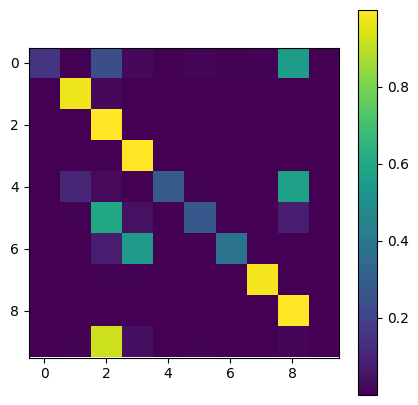

In [11]:
# Visualise attention scores
print(scores.shape)
#3 examples 10x10 matrix since sequence of length 10, comparing to all

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (5,5))
im = ax.imshow(scores[0].numpy())
fig.colorbar(im)
plt.show()
#each row is query vector in sequence and columns are weithts assigned to each value vector in the sequence

In [26]:
# Define some dummy value inputs

# NOW DO NON SELF ATTENTION
#sequence length 8, can be different to values
values = tf.random.gamma((3,8,16), alpha = 2., beta = 2.)

In [27]:
# Cross-attention

h, scores = attention([queries,values], return_attention_scores = True)
h.shape
#makes sense as doing weighed sum of value vectors for each query vector

TensorShape([3, 10, 16])

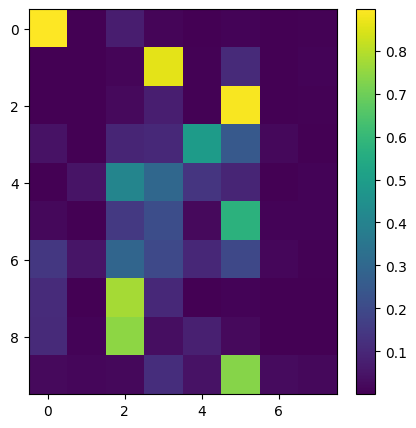

In [28]:
# Visualise attention scores

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (5,5))
im = ax.imshow(scores[0].numpy())
fig.colorbar(im)
plt.show()

#each row is query vector in sequence and columns are weithts assigned to each value vector in the sequence
#since the weights are made using the query at each timestep nq
#8 value vectors for each example in the patch
#this is for the first example in the batch

In [29]:
# Define some dummy key inputs
#same sequence length as values
keys = tf.random.gamma((3,8,16),alpha = 2., beta = 2.)

In [30]:
# Cross-attention between the queries and keys, using values

h, scores = attention([queries,values,keys], return_attention_scores = True)


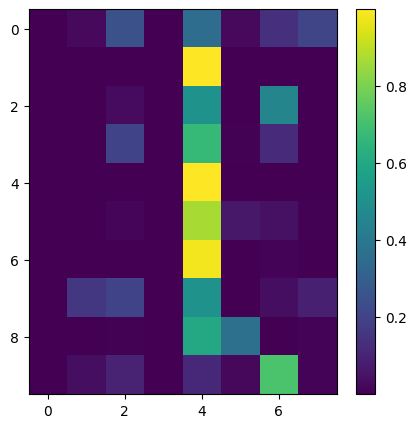

In [31]:
# Visualise attention scores

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (5,5))
im = ax.imshow(scores[0].numpy())
fig.colorbar(im)
plt.show()


#### MultiHeadAttention layer

In [37]:
# Create a MultiHeadAttention layer

from keras.layers import MultiHeadAttention

#specify key dim as the projection stuff, dk
#does same for value dim
mha = MultiHeadAttention(num_heads = 4, key_dim=32)

In [38]:
# Create some dummy inputs
source = tf.random.gamma((3,8,16), alpha = 2., beta = 0.5)
targets = tf.random.gamma((3,6,16), alpha = 2., beta = 0.5)

In [43]:
# Self-attention

#when calling mha, can just do this as queries and values (then key follows values)
#values tensor used for keys and values
h, scores = mha(source, source, return_attention_scores = True)
print(h.shape)
print(scores.shape)

(3, 8, 16)
(3, 4, 8, 8)


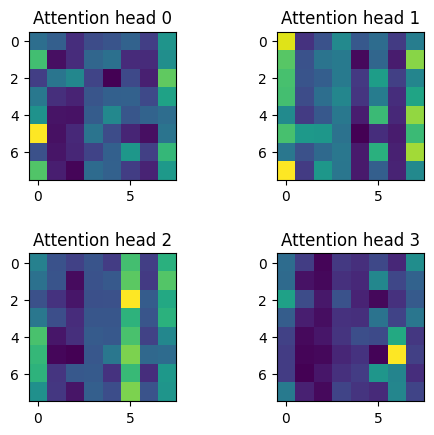

In [41]:
# Visualise attention scores

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(scores[0, i].numpy())
    ax.set_title(f"Attention head {i}")
fig.subplots_adjust(wspace=0.0, hspace=0.5)
plt.show()

In [49]:
# Create a MultiHeadAttention layer for encoder-decoder attention

#targets are queries
mha2 = MultiHeadAttention(num_heads = 4, key_dim = 32)

In [50]:
# Encoder-decoder attention

#gain keys are set to values, source
h,scores = mha2(targets,source,return_attention_scores = True )
print(h.shape)
print(scores.shape)


(3, 6, 16)
(3, 4, 6, 8)


In [52]:
# Decoder masked self-attention
#stop future context being taken into account since we havent predicted it yet

h,scores = mha2(targets,targets,return_attention_scores = True, use_causal_mask = True)
print(h.shape)
print(scores.shape)

(3, 6, 16)
(3, 4, 6, 6)


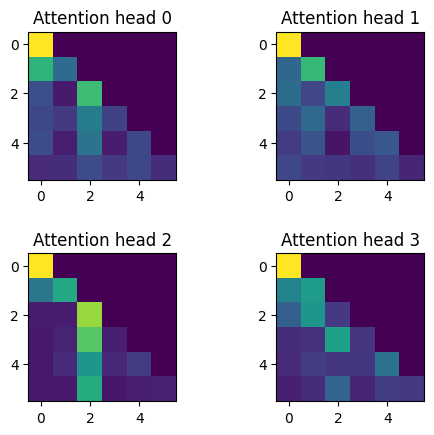

In [53]:
# Visualise attention scores

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(scores[0, i].numpy())
    ax.set_title(f"Attention head {i}")
fig.subplots_adjust(wspace=0.0, hspace=0.5)
plt.show()
#get 0 on upper triangle

In [57]:
# Define an attention mask

#define our own, should be broadcastable against attention scores tensor
#so see 3 block ago, shape was 3x4x6x8 for cross
#so define 6x8 boolean mask
mask = tf.tile(tf.constant([[True,True,True,True,False,False,False,False]]), tf.constant([6,1]))
mask


<tf.Tensor: shape=(6, 8), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False]])>

In [59]:
# Encoder-decoder masked attention

#can apply use_causal_mask too to get combination
h,scores = mha2(targets,source,return_attention_scores = True, attention_mask = mask)
print(h.shape)
print(scores.shape)

(3, 6, 16)
(3, 4, 6, 8)


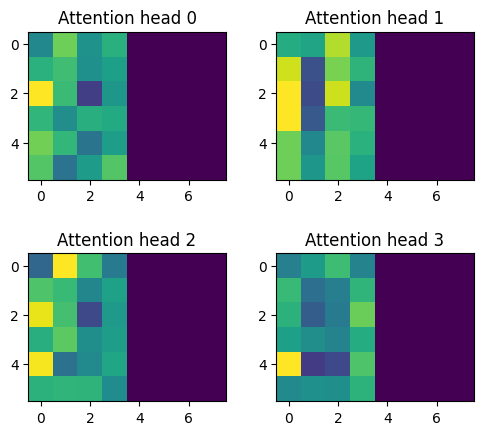

In [60]:
# Visualise attention scores

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(scores[0, i].numpy())
    ax.set_title(f"Attention head {i}")
fig.subplots_adjust(wspace=0.0, hspace=0.5)
plt.show()

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Ba16"></a>
* Ba, J.L., Kiros, J.R. & Hinton, G.E. (2016), "Layer Normalization", arXiv preprint, abs/1607.06450.
<a class="anchor" id="Borsos22"></a>
* Borsos, Z., Marinier, R., Vincent, D., Kharitonov, E., Pietquin, O., Sharifi, M., Teboul, O., Grangier, D., Tagliasacchi, M. & Zeghidour, N. (2022), "AudioLM: a Language Modeling Approach to Audio Generation", arXiv preprint, abs/2209.03143.
<a class="anchor" id="Brown20"></a>
* Brown, T., Mann, B., Ryder, N., Subbiah, M., Kaplan, J.D., Dhariwal, P., Neelakantan, A., Shyam, P., Sastry, G., Askell, A., Agarwal, S., Herbert-Voss, A., Krueger, G., Henighan, T., Child, R., Ramesh, A., Ziegler, D., Wu, J., Winter, C., Hesse, C., Chen, M., Sigler, E., Litwin, M., Gray, S., Chess, B., Clark, J., Berner, C., McCandlish, S., Radford, A., Sutskever, I. & Amodei, D. (2020), "Language Models are Few-Shot Learners", Advances in Neural Information Processing Systems, **33**, 1877-1901.
<a class="anchor" id="Chowdhery22"></a>
* Chowdhery, A., Narang, S., Devlin, J., Bosma, M., Mishra, G., Roberts, A., Barham, P., Chung, H.W., Sutton, C., Gehrmann, S., Schuh, P. Shi, K., Tsvyashchenko, S., Maynez, J., Rao, A., Barnes, P., Tay, Y., Shazeer, N., Prabhakaran, V., Reif, E., Du, N., Hutchinson, B., Pope, R., Bradbury, J., Austin, J., Isard, M., Gur-Ari, G., Yin, P., Duke, T., Levskaya, A., Ghemawat, S., Dev, S., Michalewski, H., Garcia, X., Misra, V., Robinson, K., Fedus, L., Zhou, D., Ippolito, D., Luan, D., Lim, H., Zoph, B., Spiridonov, A., Sepassi, R., Dohan, D., Agrawal, S., Omernick, M., Dai, A.M., Pillai, T.S., Pellat, M., Lewkowycz, A., Moreira, E., Child, R., Polozov, O., Lee, K., Zhou, Z., Wang, X., Saeta, B., Diaz, M., Firat, O., Catasta, M., Wei, J., Meier-Hellstern, K., Eck, D., Dean, J., Petrov, S. & Fiedel N. (2022), "PaLM: Scaling Language Modeling with Pathways", arXiv preprint, abs/2204.02311.
<a class="anchor" id="Devlin18"></a>
* Devlin, J., Chang, M.-W., Lee, K. & Toutanova, K. (2018), "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", arXiv preprint, abs/1810.04805.
<a class="anchor" id="Dosovitskiy21"></a>
* Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J. & Houlsby, N. (2021), "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", International Conference on Learning Representations, 2021.
<a class="anchor" id="Jumper21"></a>
* Jumper, J., Evans, R., Pritzel, A., Green, T., Figurnov, M., Ronneberger, O., Tunyasuvunakool, K., Bates, R., Zidek, A., Potapenko, A., Bridgland, A., Meyer, C., Kohl, S.A.A., Ballard, A.J., Cowie, A., Romera-Paredes, B., Nikolov, S., Jain, R., Adler, J., Back, T., Petersen, S., Reiman, D., Clancy, E., Zielinski, M., Steinegger, M., Pacholska, M., Berghammer, T., Bodenstein, S., Silver, D., Vinyals, O., Senior, A.W., Kavukcuoglu, K., Kohli, P. & Hassabis, D. (2021), "Highly accurate protein structure prediction with AlphaFold", Nature, **596** (7873), 583-589.
<a class="anchor" id="Liu21"></a>
* Liu, H.-I. & Chen, W.-L. (2021), "Re-Transformer: A Self-Attention Based Model for Machine Translation", Procedia Computer Science, **189**, 3-10.
<a class="anchor" id="Sennrich15"></a>
* Sennrich, R., Haddow, B. & Birch, A. (2015), "Neural Machine Translation of Rare Words with Subword Units", arXiv preprint, abs/1508.07909.
<a class="anchor" id="Thoppilan22"></a>
* Thoppilan, R., De Freitas, D., Hall, J., Shazeer, N., Kulshreshtha, A., Cheng, H.-T., Jin, A., Bos, T., Baker, L., Du, Y., Li, Y., Lee, H., Zheng, H.S., Ghafouri, A., Menegali, M., Huang, Y., Krikun, M., Lepikhin, D., Qin, J., Chen, D., Xu, Y., Chen, Z., Roberts, A., Bosma, M., Zhao, V., Zhou, Y., Chang, C.-C., Krivokon, I., Rusch, W., Pickett, M., Srinivasan, P., Man, L., Meier-Hellstern, K., Morris, M.R., Doshi, T., Delos Santos, R., Duke, T., Soraker, J., Zevenbergen, B., Prabhakaran, V., Diaz, M., Hutchinson, B., Olson, K., Molina, A., Hoffman-John, E., Lee, J., Aroyo, L., Rajakumar, R., Butryna, A., Lamm, M., Kuzmina, V., Fenton, J., Cohen, A., Bernstein, R., Kurzweil, R., Aguera-Arcas, B., Cui, C., Croak, M., Chi, E. & Le, Q. (2022), "LaMDA: Language Models for Dialog Applications", arXiv preprint, abs/2201.08239.
<a class="anchor" id="Vaswani17"></a>
* Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, L. & Polosukhin, I. (2017), "Attention is all you need", Advances in Neural Information Processing Systems, **30**, 5998-6008.